In [2]:
%matplotlib inline
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
# Imports from light automl package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

##fix random seeds
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.25 # Test size for metric check
TIMEOUT =3*3600 # Time in seconds for automl run

##fix seeds and threads
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

#load datasets
##train data
df = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\train.csv')
##pseudo test data set based o our very best  submission
df_pseudo = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\high2.csv')
##test data
df_test = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\test.csv')
##replace the test values with  the  pseudo values
df_test['Survived'] =  df_pseudo['Survived'].values
##perform  feature engineering and data preprocessing

df.drop(['PassengerId','Ticket'],axis=1,inplace=True)

##convert certain categorical data to numerical data
df['Sex'].replace('male',10,inplace=True)
df['Sex'].replace('female',20,inplace=True)
df['Embarked'].replace('C',50,inplace=True)
df['Embarked'].replace('S',60,inplace=True)
df['Embarked'].replace('Q',70,inplace=True)
##strip off special characters
df['Name'] = df['Name'].apply(lambda x:''.join([c for c in x if c.isalnum()]))
##convert to a iterable datatype (str)
df['Cabin'] = df['Cabin'].apply(lambda x : ''.join([i for i in str(x) if i.isalnum()]))
int_columns = ['Age','Fare']

##perform imputation on missing values in a numerical column
for col in int_columns:
  df[col].fillna(np.mean(df[col]),inplace=True)
df.fillna(-99999,axis=1,inplace=True)

##encode initially using label encoding
labelencoder = LabelEncoder()

df['Name'] = labelencoder.fit_transform(df['Name'])
df['Cabin'] = labelencoder.fit_transform(df['Cabin'])
##visualize the colinearity of the features
# corre = df.corr()
# sns.heatmap(corre)

# X = df.drop(['Survived'],axis=1)
# Y = df['Survived']
# stdscale = StandardScaler()

# ##scale the dataset
# X = pd.DataFrame(stdscale.fit_transform(X),columns=X.columns)

##perform feature engineering on the  test set
df_test.drop(['PassengerId','Ticket'],axis=1,inplace=True)

##convert certain categorical data to numerical data
df_test['Sex'].replace('male',10,inplace=True)
df_test['Sex'].replace('female',20,inplace=True)
df_test['Embarked'].replace('C',50,inplace=True)
df_test['Embarked'].replace('S',60,inplace=True)
df_test['Embarked'].replace('Q',70,inplace=True)
##strip off special characters
df_test['Name'] = df_test['Name'].apply(lambda x:''.join([c for c in x if c.isalnum()]))
##convert to a iterable datatype (str)
df_test['Cabin'] = df_test['Cabin'].apply(lambda x : ''.join([i for i in str(x) if i.isalnum()]))
int_columns = ['Age','Fare']

##perform imputation on missing values in a numerical column
for col in int_columns:
  df_test[col].fillna(np.mean(df_test[col]),inplace=True)
df_test.fillna(-99999,axis=1,inplace=True)

##encode initially using label encoding
labelencoder = LabelEncoder()

df_test['Name'] = labelencoder.fit_transform(df_test['Name'])
df_test['Cabin'] = labelencoder.fit_transform(df_test['Cabin'])

In [3]:
##merge the sets together to create a more robust machine learning model
pseudo_df = pd.concat([df,df_test]).reset_index(drop=True)
print(pseudo_df.head(),pseudo_df.shape)

   Survived  Pclass   Name  Sex        Age  SibSp  Parch   Fare  Cabin  \
0         1       1  60779   10  38.355472      2      0  27.14  12811   
1         0       3  10326   10  38.355472      0      0  13.35  26992   
2         0       3  61903   10   0.330000      1      2  71.29  26992   
3         0       3  45334   10  19.000000      0      0  13.04  26992   
4         1       3   7650   10  25.000000      0      0   7.76  26992   

   Embarked  
0      60.0  
1      60.0  
2      60.0  
3      60.0  
4      60.0   (200000, 10)


In [4]:
##create task
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def roc_auc_metric(y_true, y_pred, sample_weight, **kwargs):
    mask = (sample_weight > 1)
    return roc_auc_score(y_true[mask], y_pred[mask])

task = Task('binary', metric = roc_auc_metric, greater_is_better=True)

In [5]:
# Add weights for metric calculation only by true targets
pseudo_df['weight'] = [1.01] * len(df) + [0.99] * len(df_test)
##set column roles
roles = {
    'target': 'Survived',
    'weights': 'weight' # To calculate metric only on real targets
}


In [6]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': 10000,
    'objective': 'binary',
    'learning_rate': 0.02,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240
}

cb_params = {
    'max_depth':6,
    'max_ctr_complexity': 5,
    'num_trees': 50000,
    'od_wait': 500,
    'od_type':'Iter', 
    'learning_rate': 0.04,
    'min_data_in_leaf': 3
}

In [10]:
cnt_trained = 0
results = []
for it, rs in enumerate(range(2000, 2015)):
    print('=' * 30)
    print('START RANDOM_STATE = {}'.format(rs))
    print('=' * 30)
    
    # Train AutoML
    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           general_params = {'use_algos': [['linear_l2', 'lgb', 'cb']]},
                           selection_params = {'mode': 0},
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': rs},
                           lgb_params = {'default_params': params, 'freeze_defaults': True},
                           cb_params = {'default_params': cb_params, 'freeze_defaults': True})
    
    oof_pred = automl.fit_predict(pseudo_df, roles = roles)
    
    # Predict on test
    test_pred = automl.predict(df_test)
    cnt_trained += 1
    
    # Save predictions
    if it == 0:
        oof_pred_full = oof_pred.data[:, 0].copy()
        test_pred_full = test_pred.data[:, 0].copy()
    else:
        oof_pred_full += oof_pred.data[:, 0]
        test_pred_full += test_pred.data[:, 0]
    
    # Check scores for current predict and aggregated one
    acc_usual = acc_score(df['Survived'].values, oof_pred.data[:len(df), 0])
    acc_full = acc_score(df['Survived'].values, oof_pred_full[:len(df)] / cnt_trained)
    results.append((acc_usual, acc_full, acc_full - acc_usual))
    
    print('Check scores...')
    print('OOF score: {}'.format(acc_usual))
    print('OOF score full: {}'.format(acc_full))
    print('Difference: {}'.format(acc_full - acc_usual))

START RANDOM_STATE = 2000
Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (200000, 11)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10780.699026584625 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8111936388333965
Linear model: C = 5e-05 score = 0.8129716041542582
Linear model: C = 0.0001 score = 0.8127413992225638
Linear model: C = 0.0005 score = 0.8115472677397462

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8210808333321108
Linear model: C = 5e-05 score = 0.8240463424680959
Linear model: C = 0.0001 score = 0.8238629389519971
Linear model: C = 0.0005 score = 0.8233475508244336

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.81423554895917

[500]	valid's binary_logloss: 0.278029	valid's Opt metric: 0.846252
[600]	valid's binary_logloss: 0.276924	valid's Opt metric: 0.846316
[700]	valid's binary_logloss: 0.276456	valid's Opt metric: 0.8463
[800]	valid's binary_logloss: 0.276009	valid's Opt metric: 0.846279
Early stopping, best iteration is:
[708]	valid's binary_logloss: 0.276415	valid's Opt metric: 0.846325

===== Start working with fold 7 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.33894	valid's Opt metric: 0.84086
[200]	valid's binary_logloss: 0.295001	valid's Opt metric: 0.841417
[300]	valid's binary_logloss: 0.284105	valid's Opt metric: 0.842117
[400]	valid's binary_logloss: 0.279655	valid's Opt metric: 0.842633
[500]	valid's binary_logloss: 0.278099	valid's Opt metric: 0.842773
[600]	valid's binary_logloss: 0.277271	valid's Opt metric: 0.842846
[700]	valid's binary_logloss: 0.276754	valid's Opt metric: 0.84281
Early stopping, best

300:	learn: 0.2782793	test: 0.2779895	best: 0.2779895 (300)	total: 43.9s	remaining: 2h 41s
400:	learn: 0.2754367	test: 0.2763660	best: 0.2763514 (395)	total: 51.2s	remaining: 1h 45m 32s
500:	learn: 0.2730870	test: 0.2751082	best: 0.2751082 (500)	total: 58.6s	remaining: 1h 36m 32s
600:	learn: 0.2712654	test: 0.2745360	best: 0.2745360 (600)	total: 1m 5s	remaining: 1h 30m 5s
700:	learn: 0.2694621	test: 0.2739131	best: 0.2739131 (700)	total: 1m 12s	remaining: 1h 24m 56s
800:	learn: 0.2679287	test: 0.2735139	best: 0.2735115 (790)	total: 1m 30s	remaining: 1h 32m 54s
900:	learn: 0.2665662	test: 0.2734069	best: 0.2734013 (890)	total: 1m 37s	remaining: 1h 28m 44s
1000:	learn: 0.2651998	test: 0.2730996	best: 0.2730931 (999)	total: 1m 44s	remaining: 1h 25m 20s
1100:	learn: 0.2640009	test: 0.2730007	best: 0.2729930 (1097)	total: 1m 51s	remaining: 1h 22m 29s
1200:	learn: 0.2627845	test: 0.2727626	best: 0.2727626 (1200)	total: 1m 58s	remaining: 1h 20m 3s
1300:	learn: 0.2615704	test: 0.2724451	best: 

400:	learn: 0.2748892	test: 0.2810113	best: 0.2810102 (399)	total: 27.2s	remaining: 56m 5s
500:	learn: 0.2727378	test: 0.2802012	best: 0.2802012 (500)	total: 34.2s	remaining: 56m 22s
600:	learn: 0.2708477	test: 0.2797734	best: 0.2797606 (597)	total: 41.4s	remaining: 56m 40s
700:	learn: 0.2691690	test: 0.2791805	best: 0.2791805 (700)	total: 48.2s	remaining: 56m 27s
800:	learn: 0.2675694	test: 0.2786315	best: 0.2786315 (800)	total: 55.2s	remaining: 56m 32s
900:	learn: 0.2660546	test: 0.2782711	best: 0.2782349 (875)	total: 1m 2s	remaining: 56m 22s
1000:	learn: 0.2647228	test: 0.2780580	best: 0.2780509 (999)	total: 1m 8s	remaining: 56m 14s
1100:	learn: 0.2633573	test: 0.2778075	best: 0.2778075 (1100)	total: 1m 15s	remaining: 56m 10s
1200:	learn: 0.2621881	test: 0.2777141	best: 0.2777117 (1199)	total: 1m 22s	remaining: 56m 2s
1300:	learn: 0.2610499	test: 0.2776140	best: 0.2775843 (1272)	total: 1m 29s	remaining: 55m 49s
1400:	learn: 0.2598788	test: 0.2774789	best: 0.2774707 (1311)	total: 1m 

900:	learn: 0.2660420	test: 0.2768538	best: 0.2767629 (880)	total: 1m 4s	remaining: 58m 18s
1000:	learn: 0.2647624	test: 0.2766697	best: 0.2766620 (998)	total: 1m 11s	remaining: 58m 15s
1100:	learn: 0.2635378	test: 0.2764321	best: 0.2764081 (1068)	total: 1m 18s	remaining: 58m
1200:	learn: 0.2623427	test: 0.2762964	best: 0.2762964 (1200)	total: 1m 25s	remaining: 57m 43s
1300:	learn: 0.2612881	test: 0.2763154	best: 0.2762781 (1204)	total: 1m 32s	remaining: 57m 32s
1400:	learn: 0.2601536	test: 0.2762836	best: 0.2762413 (1389)	total: 1m 39s	remaining: 57m 16s
1500:	learn: 0.2591316	test: 0.2762621	best: 0.2762369 (1492)	total: 1m 45s	remaining: 56m 56s
1600:	learn: 0.2580936	test: 0.2761876	best: 0.2761535 (1576)	total: 1m 52s	remaining: 56m 43s
1700:	learn: 0.2571492	test: 0.2761083	best: 0.2761083 (1700)	total: 1m 59s	remaining: 56m 28s
1800:	learn: 0.2561181	test: 0.2758838	best: 0.2758646 (1797)	total: 2m 6s	remaining: 56m 17s
1900:	learn: 0.2552380	test: 0.2758969	best: 0.2758615 (180

Linear model: C = 5e-05 score = 0.8140156893580965
Linear model: C = 0.0001 score = 0.8137667402472196
Linear model: C = 0.0005 score = 0.8129226107097616
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 10756.899665355682
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.338964	valid's Opt metric: 0.843323
[200]	valid's binary_logloss: 0.295175	valid's Opt metric: 0.843965
[300]	valid's binary_logloss: 0.284305	valid's Opt metric: 0.84434
[400]	valid's binary_logloss: 0.280203	valid's Opt metric: 0.844527
[500]	valid's binary_logloss: 0.278613	valid's Opt metric: 0.844929
[600]	valid's binary_logloss: 0.277882	valid's Opt metric: 0.844956
[700]	valid's binary_logloss: 0.277424	valid's Opt metric: 0.845026
[800]	valid's binary_logloss: 0.277049	valid's Opt metric: 0.845023
[900]	valid's binary_logloss: 0.

500:	learn: 0.2726075	test: 0.2799475	best: 0.2799428 (496)	total: 35.5s	remaining: 58m 23s
600:	learn: 0.2706826	test: 0.2794118	best: 0.2793902 (596)	total: 42.5s	remaining: 58m 15s
700:	learn: 0.2688790	test: 0.2788918	best: 0.2788899 (698)	total: 49.7s	remaining: 58m 14s
800:	learn: 0.2673318	test: 0.2785300	best: 0.2785300 (800)	total: 56.7s	remaining: 58m 2s
900:	learn: 0.2659375	test: 0.2781790	best: 0.2781664 (897)	total: 1m 3s	remaining: 57m 44s
1000:	learn: 0.2646186	test: 0.2780182	best: 0.2780131 (995)	total: 1m 10s	remaining: 57m 30s
1100:	learn: 0.2633412	test: 0.2779585	best: 0.2779309 (1097)	total: 1m 17s	remaining: 57m 17s
1200:	learn: 0.2621452	test: 0.2777528	best: 0.2777514 (1199)	total: 1m 24s	remaining: 57m 4s
1300:	learn: 0.2610683	test: 0.2778106	best: 0.2777514 (1199)	total: 1m 31s	remaining: 56m 48s
1400:	learn: 0.2600193	test: 0.2776902	best: 0.2776504 (1384)	total: 1m 37s	remaining: 56m 38s
1500:	learn: 0.2589818	test: 0.2778112	best: 0.2776504 (1384)	total:

400:	learn: 0.2751413	test: 0.2794690	best: 0.2794690 (400)	total: 27.9s	remaining: 57m 29s
500:	learn: 0.2726366	test: 0.2783985	best: 0.2783985 (500)	total: 34.7s	remaining: 57m 8s
600:	learn: 0.2708111	test: 0.2780191	best: 0.2780171 (598)	total: 41.8s	remaining: 57m 18s
700:	learn: 0.2691698	test: 0.2774287	best: 0.2774230 (697)	total: 48.7s	remaining: 57m 5s
800:	learn: 0.2674097	test: 0.2768283	best: 0.2768166 (798)	total: 55.7s	remaining: 57m 1s
900:	learn: 0.2660393	test: 0.2766190	best: 0.2766183 (897)	total: 1m 2s	remaining: 56m 48s
1000:	learn: 0.2646874	test: 0.2762244	best: 0.2762244 (1000)	total: 1m 9s	remaining: 56m 39s
1100:	learn: 0.2634533	test: 0.2761194	best: 0.2761134 (1098)	total: 1m 16s	remaining: 56m 39s
1200:	learn: 0.2622664	test: 0.2759270	best: 0.2759270 (1200)	total: 1m 23s	remaining: 56m 28s
1300:	learn: 0.2610142	test: 0.2756122	best: 0.2756122 (1300)	total: 1m 30s	remaining: 56m 24s
1400:	learn: 0.2599538	test: 0.2754675	best: 0.2754455 (1365)	total: 1m 

400:	learn: 0.2744408	test: 0.2836651	best: 0.2836651 (400)	total: 28.3s	remaining: 58m 17s
500:	learn: 0.2722777	test: 0.2827827	best: 0.2827827 (500)	total: 35.4s	remaining: 58m 17s
600:	learn: 0.2703634	test: 0.2820369	best: 0.2820369 (600)	total: 42.4s	remaining: 58m 4s
700:	learn: 0.2686646	test: 0.2815602	best: 0.2815602 (700)	total: 49.4s	remaining: 57m 52s
800:	learn: 0.2670341	test: 0.2813400	best: 0.2813068 (785)	total: 56.3s	remaining: 57m 39s
900:	learn: 0.2656579	test: 0.2810983	best: 0.2810857 (894)	total: 1m 3s	remaining: 57m 30s
1000:	learn: 0.2643868	test: 0.2809009	best: 0.2809009 (1000)	total: 1m 10s	remaining: 57m 23s
1100:	learn: 0.2631582	test: 0.2807480	best: 0.2807193 (1096)	total: 1m 17s	remaining: 57m 19s
1200:	learn: 0.2619042	test: 0.2805605	best: 0.2804861 (1190)	total: 1m 24s	remaining: 57m 16s
1300:	learn: 0.2607763	test: 0.2804932	best: 0.2804861 (1190)	total: 1m 31s	remaining: 57m 5s
1400:	learn: 0.2596945	test: 0.2803949	best: 0.2803841 (1369)	total: 1

900:	learn: 0.2650144	test: 0.2829095	best: 0.2829071 (894)	total: 1m 2s	remaining: 56m 42s
1000:	learn: 0.2637386	test: 0.2827445	best: 0.2827389 (999)	total: 1m 9s	remaining: 56m 39s
1100:	learn: 0.2624382	test: 0.2824346	best: 0.2824346 (1100)	total: 1m 16s	remaining: 56m 32s
1200:	learn: 0.2613214	test: 0.2824750	best: 0.2824045 (1130)	total: 1m 23s	remaining: 56m 45s
1300:	learn: 0.2602275	test: 0.2824181	best: 0.2823974 (1289)	total: 1m 30s	remaining: 56m 33s
1400:	learn: 0.2591328	test: 0.2823061	best: 0.2823061 (1400)	total: 1m 37s	remaining: 56m 23s
1500:	learn: 0.2580721	test: 0.2822560	best: 0.2822155 (1439)	total: 1m 44s	remaining: 56m 21s
1600:	learn: 0.2570780	test: 0.2821916	best: 0.2821760 (1582)	total: 1m 51s	remaining: 56m 10s
1700:	learn: 0.2560557	test: 0.2821134	best: 0.2821128 (1699)	total: 1m 58s	remaining: 55m 59s
1800:	learn: 0.2550805	test: 0.2821360	best: 0.2820604 (1740)	total: 2m 5s	remaining: 55m 46s
1900:	learn: 0.2542164	test: 0.2821706	best: 0.2820604 (

Early stopping, best iteration is:
[855]	valid's binary_logloss: 0.277569	valid's Opt metric: 0.844536

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.343842	valid's Opt metric: 0.838582
[200]	valid's binary_logloss: 0.3005	valid's Opt metric: 0.839711
[300]	valid's binary_logloss: 0.289522	valid's Opt metric: 0.840683
[400]	valid's binary_logloss: 0.284975	valid's Opt metric: 0.841247
[500]	valid's binary_logloss: 0.283506	valid's Opt metric: 0.841505
[600]	valid's binary_logloss: 0.282474	valid's Opt metric: 0.841674
[700]	valid's binary_logloss: 0.281849	valid's Opt metric: 0.841856
[800]	valid's binary_logloss: 0.281467	valid's Opt metric: 0.841784
Early stopping, best iteration is:
[708]	valid's binary_logloss: 0.281787	valid's Opt metric: 0.841884

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve

1100:	learn: 0.2639162	test: 0.2730437	best: 0.2729527 (1033)	total: 1m 19s	remaining: 58m 36s
1200:	learn: 0.2627936	test: 0.2728914	best: 0.2728633 (1184)	total: 1m 26s	remaining: 58m 33s
1300:	learn: 0.2616567	test: 0.2729284	best: 0.2728633 (1184)	total: 1m 33s	remaining: 58m 34s
1400:	learn: 0.2605938	test: 0.2728466	best: 0.2728426 (1372)	total: 1m 41s	remaining: 58m 26s
1500:	learn: 0.2595124	test: 0.2728306	best: 0.2728113 (1490)	total: 1m 48s	remaining: 58m 19s
1600:	learn: 0.2585597	test: 0.2727507	best: 0.2727481 (1598)	total: 1m 55s	remaining: 58m 6s
1700:	learn: 0.2576108	test: 0.2728202	best: 0.2727166 (1640)	total: 2m 2s	remaining: 57m 52s
1800:	learn: 0.2567413	test: 0.2728798	best: 0.2727166 (1640)	total: 2m 9s	remaining: 57m 40s
1900:	learn: 0.2558700	test: 0.2728517	best: 0.2727166 (1640)	total: 2m 16s	remaining: 57m 29s
2000:	learn: 0.2549519	test: 0.2727782	best: 0.2727166 (1640)	total: 2m 23s	remaining: 57m 16s
2100:	learn: 0.2538975	test: 0.2725025	best: 0.272488

900:	learn: 0.2665966	test: 0.2739851	best: 0.2739773 (898)	total: 1m 3s	remaining: 58m 3s
1000:	learn: 0.2650305	test: 0.2736717	best: 0.2736690 (995)	total: 1m 10s	remaining: 57m 50s
1100:	learn: 0.2637337	test: 0.2735780	best: 0.2735701 (1089)	total: 1m 18s	remaining: 57m 51s
1200:	learn: 0.2624837	test: 0.2733833	best: 0.2733603 (1194)	total: 1m 25s	remaining: 57m 40s
1300:	learn: 0.2613859	test: 0.2732395	best: 0.2732309 (1297)	total: 1m 32s	remaining: 57m 31s
1400:	learn: 0.2602695	test: 0.2731397	best: 0.2731397 (1400)	total: 1m 39s	remaining: 57m 33s
1500:	learn: 0.2592468	test: 0.2732807	best: 0.2731379 (1401)	total: 1m 46s	remaining: 57m 24s
1600:	learn: 0.2582670	test: 0.2733595	best: 0.2731379 (1401)	total: 1m 53s	remaining: 57m 20s
1700:	learn: 0.2572887	test: 0.2733719	best: 0.2731379 (1401)	total: 2m	remaining: 57m 11s
1800:	learn: 0.2563373	test: 0.2734556	best: 0.2731379 (1401)	total: 2m 8s	remaining: 57m 7s
1900:	learn: 0.2554166	test: 0.2734522	best: 0.2731379 (1401)

2100:	learn: 0.2536829	test: 0.2730337	best: 0.2729108 (1908)	total: 2m 52s	remaining: 1h 5m 43s
2200:	learn: 0.2528568	test: 0.2730960	best: 0.2729108 (1908)	total: 3m	remaining: 1h 5m 20s
2300:	learn: 0.2520357	test: 0.2731900	best: 0.2729108 (1908)	total: 3m 7s	remaining: 1h 4m 53s
2400:	learn: 0.2512015	test: 0.2733257	best: 0.2729108 (1908)	total: 3m 15s	remaining: 1h 4m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2729108328
bestIteration = 1908

Shrink model to first 1909 iterations.

===== Start working with fold 8 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6403423	test: 0.6398298	best: 0.6398298 (0)	total: 68.3ms	remaining: 56m 56s
100:	learn: 0.2885685	test: 0.2858302	best: 0.2858302 (100)	total: 7.04s	remaining: 57m 57s
200:	learn: 0.2814570	test: 0.2797285	best: 0.2797285 (200)	total: 14.2s	remaining: 58m 34s
300:	learn: 0.2782579	test: 0.2777315	best: 0.2777315 (300)	total: 21.4s	remaining: 58m 45s
400:	learn: 0.2753888	test: 0.2762874	b

Linear model: C = 5e-05 score = 0.8053061492641906
Linear model: C = 0.0001 score = 0.8055701159246869
Linear model: C = 0.0005 score = 0.8049576645158731
Linear model: C = 0.001 score = 0.8047146052875143

===== Start working with fold 8 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8118875572130071
Linear model: C = 5e-05 score = 0.8138245157157289
Linear model: C = 0.0001 score = 0.8135671353128916
Linear model: C = 0.0005 score = 0.8129137304236258

===== Start working with fold 9 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8104330289509946
Linear model: C = 5e-05 score = 0.8129684130919488
Linear model: C = 0.0001 score = 0.81296419122488
Linear model: C = 0.0005 score = 0.8126166520227027
Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 10659.616669416428
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores

1200:	learn: 0.2630730	test: 0.2687947	best: 0.2687947 (1200)	total: 1m 33s	remaining: 1h 3m 22s
1300:	learn: 0.2619494	test: 0.2685904	best: 0.2685904 (1300)	total: 1m 41s	remaining: 1h 3m 23s
1400:	learn: 0.2608859	test: 0.2685177	best: 0.2684965 (1393)	total: 1m 49s	remaining: 1h 3m 25s
1500:	learn: 0.2598501	test: 0.2683871	best: 0.2683866 (1475)	total: 1m 57s	remaining: 1h 3m 9s
1600:	learn: 0.2588573	test: 0.2681977	best: 0.2681977 (1600)	total: 2m 6s	remaining: 1h 3m 44s
1700:	learn: 0.2578265	test: 0.2680163	best: 0.2679859 (1682)	total: 2m 13s	remaining: 1h 3m 23s
1800:	learn: 0.2569159	test: 0.2679655	best: 0.2678970 (1769)	total: 2m 21s	remaining: 1h 3m 11s
1900:	learn: 0.2559947	test: 0.2678466	best: 0.2677960 (1859)	total: 2m 29s	remaining: 1h 3m 4s
2000:	learn: 0.2551338	test: 0.2677963	best: 0.2677824 (1992)	total: 2m 37s	remaining: 1h 2m 50s
2100:	learn: 0.2542860	test: 0.2678544	best: 0.2677824 (1992)	total: 2m 44s	remaining: 1h 2m 36s
2200:	learn: 0.2534698	test: 0.26

1200:	learn: 0.2621933	test: 0.2770377	best: 0.2770116 (1193)	total: 1m 31s	remaining: 1h 1m 44s
1300:	learn: 0.2610750	test: 0.2770034	best: 0.2770034 (1300)	total: 1m 38s	remaining: 1h 1m 26s
1400:	learn: 0.2599852	test: 0.2769071	best: 0.2768975 (1377)	total: 1m 45s	remaining: 1h 1m 15s
1500:	learn: 0.2589738	test: 0.2769818	best: 0.2768931 (1436)	total: 1m 53s	remaining: 1h 1m 11s
1600:	learn: 0.2579523	test: 0.2770217	best: 0.2768931 (1436)	total: 2m 1s	remaining: 1h 1m 4s
1700:	learn: 0.2568682	test: 0.2769317	best: 0.2768931 (1436)	total: 2m 8s	remaining: 1h 54s
1800:	learn: 0.2558527	test: 0.2767716	best: 0.2767627 (1790)	total: 2m 16s	remaining: 1h 45s
1900:	learn: 0.2549714	test: 0.2767727	best: 0.2766930 (1813)	total: 2m 23s	remaining: 1h 26s
2000:	learn: 0.2540841	test: 0.2768175	best: 0.2766930 (1813)	total: 2m 30s	remaining: 1h 18s
2100:	learn: 0.2532409	test: 0.2769951	best: 0.2766930 (1813)	total: 2m 38s	remaining: 1h 5s
2200:	learn: 0.2524121	test: 0.2770835	best: 0.27

800:	learn: 0.2680570	test: 0.2713276	best: 0.2713276 (800)	total: 1m	remaining: 1h 1m 48s
900:	learn: 0.2667088	test: 0.2711662	best: 0.2711662 (900)	total: 1m 7s	remaining: 1h 1m 34s
1000:	learn: 0.2652783	test: 0.2708999	best: 0.2708999 (1000)	total: 1m 15s	remaining: 1h 1m 22s
1100:	learn: 0.2640377	test: 0.2706710	best: 0.2706676 (1099)	total: 1m 22s	remaining: 1h 1m 8s
1200:	learn: 0.2628454	test: 0.2705267	best: 0.2705265 (1199)	total: 1m 30s	remaining: 1h 59s
1300:	learn: 0.2617355	test: 0.2704201	best: 0.2704201 (1300)	total: 1m 37s	remaining: 1h 51s
1400:	learn: 0.2605391	test: 0.2701450	best: 0.2701325 (1395)	total: 1m 45s	remaining: 1h 49s
1500:	learn: 0.2594064	test: 0.2700578	best: 0.2699980 (1481)	total: 1m 52s	remaining: 1h 39s
1600:	learn: 0.2584137	test: 0.2699601	best: 0.2699520 (1598)	total: 2m	remaining: 1h 34s
1700:	learn: 0.2574053	test: 0.2698757	best: 0.2698413 (1693)	total: 2m 7s	remaining: 1h 22s
1800:	learn: 0.2564755	test: 0.2697723	best: 0.2697723 (1800)	t

1900:	learn: 0.2546549	test: 0.2793037	best: 0.2792996 (1898)	total: 2m 47s	remaining: 1h 10m 37s
2000:	learn: 0.2537977	test: 0.2791345	best: 0.2791289 (1999)	total: 3m 10s	remaining: 1h 16m 2s
2100:	learn: 0.2529684	test: 0.2791515	best: 0.2791069 (2028)	total: 3m 18s	remaining: 1h 15m 28s
2200:	learn: 0.2520159	test: 0.2790902	best: 0.2790255 (2170)	total: 3m 28s	remaining: 1h 15m 31s
2300:	learn: 0.2512312	test: 0.2792144	best: 0.2790255 (2170)	total: 3m 37s	remaining: 1h 15m 9s
2400:	learn: 0.2504610	test: 0.2793095	best: 0.2790255 (2170)	total: 3m 48s	remaining: 1h 15m 30s
2500:	learn: 0.2496258	test: 0.2792135	best: 0.2790255 (2170)	total: 3m 56s	remaining: 1h 14m 49s
2600:	learn: 0.2489009	test: 0.2792583	best: 0.2790255 (2170)	total: 4m 4s	remaining: 1h 14m 21s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2790254981
bestIteration = 2170

Shrink model to first 2171 iterations.
Lvl_0_Pipe_1_Mod_1_CatBoost fitting and predicting completed
Time left 8369.90

[1400]	valid's binary_logloss: 0.273134	valid's Opt metric: 0.849945
Early stopping, best iteration is:
[1378]	valid's binary_logloss: 0.273139	valid's Opt metric: 0.849978

===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.335376	valid's Opt metric: 0.846865
[200]	valid's binary_logloss: 0.290095	valid's Opt metric: 0.847754
[300]	valid's binary_logloss: 0.278839	valid's Opt metric: 0.84859
[400]	valid's binary_logloss: 0.274576	valid's Opt metric: 0.848942
[500]	valid's binary_logloss: 0.27304	valid's Opt metric: 0.849125
[600]	valid's binary_logloss: 0.272169	valid's Opt metric: 0.849347
[700]	valid's binary_logloss: 0.271518	valid's Opt metric: 0.849425
[800]	valid's binary_logloss: 0.271033	valid's Opt metric: 0.849444
[900]	valid's binary_logloss: 0.270676	valid's Opt metric: 0.84955
[1000]	valid's binary_logloss: 0.270426	valid's Opt metric: 0.849623
[1100]	valid's 

2100:	learn: 0.2531513	test: 0.2801695	best: 0.2801323 (2085)	total: 2m 47s	remaining: 1h 3m 40s
2200:	learn: 0.2523306	test: 0.2803354	best: 0.2801323 (2085)	total: 2m 56s	remaining: 1h 3m 54s
2300:	learn: 0.2515212	test: 0.2803493	best: 0.2801323 (2085)	total: 3m 5s	remaining: 1h 4m 8s
2400:	learn: 0.2507096	test: 0.2803612	best: 0.2801323 (2085)	total: 3m 14s	remaining: 1h 4m 16s
2500:	learn: 0.2499120	test: 0.2804548	best: 0.2801323 (2085)	total: 3m 22s	remaining: 1h 4m 1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2801323467
bestIteration = 2085

Shrink model to first 2086 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6398382	test: 0.6394458	best: 0.6394458 (0)	total: 126ms	remaining: 1h 44m 44s
100:	learn: 0.2883704	test: 0.2860089	best: 0.2860089 (100)	total: 8.92s	remaining: 1h 13m 25s
200:	learn: 0.2816900	test: 0.2808153	best: 0.2808153 (200)	total: 15.8s	remaining: 1h 5m 24s
300:	learn: 0.2781937	tes

2600:	learn: 0.2496825	test: 0.2733213	best: 0.2731804 (2415)	total: 3m 23s	remaining: 1h 1m 41s
2700:	learn: 0.2489477	test: 0.2733452	best: 0.2731804 (2415)	total: 3m 30s	remaining: 1h 1m 20s
2800:	learn: 0.2481678	test: 0.2733118	best: 0.2731804 (2415)	total: 3m 38s	remaining: 1h 1m 22s
2900:	learn: 0.2474754	test: 0.2733075	best: 0.2731804 (2415)	total: 3m 49s	remaining: 1h 2m 8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2731803847
bestIteration = 2415

Shrink model to first 2416 iterations.

===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6401841	test: 0.6397675	best: 0.6397675 (0)	total: 103ms	remaining: 1h 25m 39s
100:	learn: 0.2877553	test: 0.2831436	best: 0.2831436 (100)	total: 8.23s	remaining: 1h 7m 44s
200:	learn: 0.2813322	test: 0.2780863	best: 0.2780863 (200)	total: 15.9s	remaining: 1h 5m 40s
300:	learn: 0.2781886	test: 0.2763120	best: 0.2763120 (300)	total: 23.5s	remaining: 1h 4m 44s
400:	learn: 0.2753954	test:

1600:	learn: 0.2584260	test: 0.2740574	best: 0.2740452 (1597)	total: 2m 17s	remaining: 1h 9m 14s
1700:	learn: 0.2574348	test: 0.2740109	best: 0.2740069 (1697)	total: 2m 25s	remaining: 1h 8m 46s
1800:	learn: 0.2564658	test: 0.2739931	best: 0.2739471 (1742)	total: 2m 33s	remaining: 1h 8m 16s
1900:	learn: 0.2555748	test: 0.2739846	best: 0.2739471 (1742)	total: 2m 41s	remaining: 1h 7m 58s
2000:	learn: 0.2547156	test: 0.2738924	best: 0.2738924 (2000)	total: 2m 50s	remaining: 1h 8m 9s
2100:	learn: 0.2537802	test: 0.2738784	best: 0.2738721 (2097)	total: 2m 57s	remaining: 1h 7m 36s
2200:	learn: 0.2529844	test: 0.2737679	best: 0.2737679 (2200)	total: 3m 5s	remaining: 1h 7m 2s
2300:	learn: 0.2521236	test: 0.2737397	best: 0.2737031 (2254)	total: 3m 12s	remaining: 1h 6m 25s
2400:	learn: 0.2513618	test: 0.2737677	best: 0.2737031 (2254)	total: 3m 19s	remaining: 1h 5m 47s
2500:	learn: 0.2505801	test: 0.2738129	best: 0.2737031 (2254)	total: 3m 26s	remaining: 1h 5m 17s
2600:	learn: 0.2498487	test: 0.27

Linear model: C = 0.0005 score = 0.8138927320114271

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8137856250174827
Linear model: C = 5e-05 score = 0.8162176360173865
Linear model: C = 0.0001 score = 0.8162055990449515
Linear model: C = 0.0005 score = 0.8156882503715989

===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8162750387551952
Linear model: C = 5e-05 score = 0.8188887066428915
Linear model: C = 0.0001 score = 0.8189520889302503
Linear model: C = 0.0005 score = 0.8183773079449197
Linear model: C = 0.001 score = 0.8181485128401258

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.815962798613877
Linear model: C = 5e-05 score = 0.817608065745539
Linear model: C = 0.0001 score = 0.817345660246813
Linear model: C = 0.0005 score = 0.8165711906220346

===== Start working with fold 5 for Lvl_0_Pipe_0_Mod_0_LinearL2 =

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.337636	valid's Opt metric: 0.844801
[200]	valid's binary_logloss: 0.293024	valid's Opt metric: 0.845822
[300]	valid's binary_logloss: 0.28213	valid's Opt metric: 0.846512
[400]	valid's binary_logloss: 0.277816	valid's Opt metric: 0.847182
[500]	valid's binary_logloss: 0.276205	valid's Opt metric: 0.847618
[600]	valid's binary_logloss: 0.275305	valid's Opt metric: 0.847835
[700]	valid's binary_logloss: 0.274853	valid's Opt metric: 0.847941
[800]	valid's binary_logloss: 0.274378	valid's Opt metric: 0.848026
[900]	valid's binary_logloss: 0.274061	valid's Opt metric: 0.848079
[1000]	valid's binary_logloss: 0.273656	valid's Opt metric: 0.848136
[1100]	valid's binary_logloss: 0.273378	valid's Opt metric: 0.848195
[1200]	valid's binary_logloss: 0.273096	valid's Opt metric: 0.848184
Early stopping, best iteration is:
[1127]	valid's binary_logloss: 0.273328	valid's Opt metric: 0.848223
Lvl_0_Pipe_1_Mod

2000:	learn: 0.2545690	test: 0.2713708	best: 0.2713573 (1996)	total: 2m 20s	remaining: 56m 16s
2100:	learn: 0.2536680	test: 0.2712419	best: 0.2711930 (2064)	total: 2m 28s	remaining: 56m 24s
2200:	learn: 0.2528100	test: 0.2712323	best: 0.2711930 (2064)	total: 2m 35s	remaining: 56m 20s
2300:	learn: 0.2519860	test: 0.2711943	best: 0.2711883 (2298)	total: 2m 42s	remaining: 56m 7s
2400:	learn: 0.2511692	test: 0.2712025	best: 0.2711603 (2340)	total: 2m 49s	remaining: 56m 1s
2500:	learn: 0.2503673	test: 0.2711489	best: 0.2711432 (2474)	total: 2m 56s	remaining: 55m 47s
2600:	learn: 0.2496147	test: 0.2711312	best: 0.2711270 (2598)	total: 3m 3s	remaining: 55m 36s
2700:	learn: 0.2488662	test: 0.2709647	best: 0.2709467 (2687)	total: 3m 9s	remaining: 55m 26s
2800:	learn: 0.2481642	test: 0.2710376	best: 0.2709467 (2687)	total: 3m 16s	remaining: 55m 14s
2900:	learn: 0.2474484	test: 0.2710560	best: 0.2709467 (2687)	total: 3m 23s	remaining: 55m 4s
3000:	learn: 0.2467143	test: 0.2710400	best: 0.2709467 

1000:	learn: 0.2650575	test: 0.2739424	best: 0.2739424 (1000)	total: 1m 9s	remaining: 57m 3s
1100:	learn: 0.2638306	test: 0.2738529	best: 0.2738217 (1035)	total: 1m 16s	remaining: 56m 55s
1200:	learn: 0.2624785	test: 0.2735050	best: 0.2735050 (1200)	total: 1m 23s	remaining: 56m 50s
1300:	learn: 0.2613615	test: 0.2733254	best: 0.2733254 (1300)	total: 1m 30s	remaining: 56m 30s
1400:	learn: 0.2601984	test: 0.2732010	best: 0.2732007 (1399)	total: 1m 37s	remaining: 56m 15s
1500:	learn: 0.2591401	test: 0.2730593	best: 0.2730327 (1491)	total: 1m 44s	remaining: 56m 2s
1600:	learn: 0.2581536	test: 0.2729613	best: 0.2729613 (1600)	total: 1m 50s	remaining: 55m 52s
1700:	learn: 0.2572256	test: 0.2730669	best: 0.2729598 (1602)	total: 1m 57s	remaining: 55m 44s
1800:	learn: 0.2562970	test: 0.2730197	best: 0.2729598 (1602)	total: 2m 4s	remaining: 55m 35s
1900:	learn: 0.2553795	test: 0.2730075	best: 0.2729598 (1602)	total: 2m 11s	remaining: 55m 25s
2000:	learn: 0.2545006	test: 0.2730657	best: 0.2729598

900:	learn: 0.2661512	test: 0.2752285	best: 0.2751776 (885)	total: 1m 4s	remaining: 58m 9s
1000:	learn: 0.2647952	test: 0.2749885	best: 0.2749868 (985)	total: 1m 11s	remaining: 58m 4s
1100:	learn: 0.2635685	test: 0.2749678	best: 0.2748970 (1062)	total: 1m 18s	remaining: 57m 50s
1200:	learn: 0.2622252	test: 0.2747698	best: 0.2747601 (1186)	total: 1m 25s	remaining: 57m 50s
1300:	learn: 0.2610756	test: 0.2747379	best: 0.2747298 (1209)	total: 1m 32s	remaining: 57m 42s
1400:	learn: 0.2599296	test: 0.2745266	best: 0.2744710 (1396)	total: 1m 40s	remaining: 57m 50s
1500:	learn: 0.2588677	test: 0.2743389	best: 0.2743389 (1500)	total: 1m 47s	remaining: 57m 48s
1600:	learn: 0.2579222	test: 0.2743081	best: 0.2742892 (1594)	total: 1m 54s	remaining: 57m 48s
1700:	learn: 0.2569712	test: 0.2742414	best: 0.2742194 (1644)	total: 2m 2s	remaining: 57m 46s
1800:	learn: 0.2559866	test: 0.2742723	best: 0.2741575 (1711)	total: 2m 9s	remaining: 57m 45s
1900:	learn: 0.2550904	test: 0.2743183	best: 0.2741575 (17

Time left 10757.045901060104
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.336883	valid's Opt metric: 0.846509
Early stopping, best iteration is:
[49]	valid's binary_logloss: 0.407884	valid's Opt metric: 0.846903

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.339287	valid's Opt metric: 0.844245
[200]	valid's binary_logloss: 0.294763	valid's Opt metric: 0.845534
[300]	valid's binary_logloss: 0.28383	valid's Opt metric: 0.846478
[400]	valid's binary_logloss: 0.279401	valid's Opt metric: 0.847181
[500]	valid's binary_logloss: 0.277832	valid's Opt metric: 0.847469
[600]	valid's binary_logloss: 0.276949	valid's Opt metric: 0.847597
[700]	valid's binary_logloss: 0.276298	valid's Opt metric: 0.847758
[800]	valid'

1800:	learn: 0.2564497	test: 0.2717098	best: 0.2716862 (1773)	total: 2m 17s	remaining: 1h 1m 30s
1900:	learn: 0.2555208	test: 0.2716374	best: 0.2716081 (1807)	total: 2m 24s	remaining: 1h 58s
2000:	learn: 0.2546649	test: 0.2716371	best: 0.2715915 (1950)	total: 2m 31s	remaining: 1h 36s
2100:	learn: 0.2538141	test: 0.2715335	best: 0.2715230 (2091)	total: 2m 38s	remaining: 1h 11s
2200:	learn: 0.2530084	test: 0.2714768	best: 0.2714511 (2193)	total: 2m 45s	remaining: 59m 46s
2300:	learn: 0.2522098	test: 0.2714409	best: 0.2714288 (2299)	total: 2m 52s	remaining: 59m 29s
2400:	learn: 0.2514242	test: 0.2714649	best: 0.2714111 (2335)	total: 2m 58s	remaining: 59m 3s
2500:	learn: 0.2506467	test: 0.2715616	best: 0.2714111 (2335)	total: 3m 5s	remaining: 58m 43s
2600:	learn: 0.2499359	test: 0.2716121	best: 0.2714111 (2335)	total: 3m 12s	remaining: 58m 30s
2700:	learn: 0.2491789	test: 0.2715889	best: 0.2714111 (2335)	total: 3m 19s	remaining: 58m 13s
2800:	learn: 0.2484285	test: 0.2716780	best: 0.271411

1900:	learn: 0.2551778	test: 0.2770653	best: 0.2768456 (1597)	total: 2m 9s	remaining: 54m 43s
2000:	learn: 0.2542850	test: 0.2770113	best: 0.2768456 (1597)	total: 2m 16s	remaining: 54m 41s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2768455626
bestIteration = 1597

Shrink model to first 1598 iterations.

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6401507	test: 0.6400813	best: 0.6400813 (0)	total: 85.9ms	remaining: 1h 11m 35s
100:	learn: 0.2868378	test: 0.2906204	best: 0.2906204 (100)	total: 6.87s	remaining: 56m 36s
200:	learn: 0.2810360	test: 0.2856511	best: 0.2856511 (200)	total: 13.6s	remaining: 56m 5s
300:	learn: 0.2777839	test: 0.2835277	best: 0.2835277 (300)	total: 20.4s	remaining: 56m 14s
400:	learn: 0.2751754	test: 0.2819071	best: 0.2819071 (400)	total: 27.5s	remaining: 56m 47s
500:	learn: 0.2728841	test: 0.2807683	best: 0.2807681 (499)	total: 34.4s	remaining: 56m 42s
600:	learn: 0.2707840	test: 0.2797521	best: 0.2

2000:	learn: 0.2540126	test: 0.2781687	best: 0.2781013 (1963)	total: 2m 49s	remaining: 1h 7m 34s
2100:	learn: 0.2531423	test: 0.2781684	best: 0.2781013 (1963)	total: 2m 55s	remaining: 1h 6m 51s
2200:	learn: 0.2522807	test: 0.2782076	best: 0.2781013 (1963)	total: 3m 2s	remaining: 1h 6m 9s
2300:	learn: 0.2513882	test: 0.2781734	best: 0.2781013 (1963)	total: 3m 10s	remaining: 1h 5m 38s
2400:	learn: 0.2505921	test: 0.2782085	best: 0.2781013 (1963)	total: 3m 18s	remaining: 1h 5m 44s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2781012907
bestIteration = 1963

Shrink model to first 1964 iterations.

===== Start working with fold 7 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6398288	test: 0.6404861	best: 0.6404861 (0)	total: 78.5ms	remaining: 1h 5m 24s
100:	learn: 0.2867144	test: 0.2979031	best: 0.2979031 (100)	total: 7.34s	remaining: 1h 26s
200:	learn: 0.2800723	test: 0.2931533	best: 0.2931533 (200)	total: 14.3s	remaining: 59m 14s
300:	learn: 0.2765506	test: 0.

Check scores...
OOF score: 0.77889
OOF score full: 0.7796
Difference: 0.0007099999999999884
START RANDOM_STATE = 2007
Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (200000, 11)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10779.908203601837 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.815254799773839
Linear model: C = 5e-05 score = 0.8165394723893021
Linear model: C = 0.0001 score = 0.8160351774448141
Linear model: C = 0.0005 score = 0.8150958548867095

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8126946803740013
Linear model: C = 5e-05 score = 0.815450878318573
Linear model: C = 0.0001 score = 0.8153299929962932
Linear model: C = 0.0005 score = 0.8149227240892243

===== Start working with fold


===== Start working with fold 7 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.340478	valid's Opt metric: 0.843415
[200]	valid's binary_logloss: 0.296961	valid's Opt metric: 0.843907
[300]	valid's binary_logloss: 0.286334	valid's Opt metric: 0.844139
[400]	valid's binary_logloss: 0.282123	valid's Opt metric: 0.844366
[500]	valid's binary_logloss: 0.280565	valid's Opt metric: 0.844684
[600]	valid's binary_logloss: 0.279688	valid's Opt metric: 0.844821
[700]	valid's binary_logloss: 0.279086	valid's Opt metric: 0.844905
[800]	valid's binary_logloss: 0.278712	valid's Opt metric: 0.844907
Early stopping, best iteration is:
[728]	valid's binary_logloss: 0.278889	valid's Opt metric: 0.84497

===== Start working with fold 8 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.340405	valid's Opt metric: 0.842494
[200]	valid's bina

1300:	learn: 0.2624428	test: 0.2721076	best: 0.2721047 (1296)	total: 1m 32s	remaining: 57m 58s
1400:	learn: 0.2613340	test: 0.2719965	best: 0.2719947 (1395)	total: 1m 40s	remaining: 58m 10s
1500:	learn: 0.2603272	test: 0.2720551	best: 0.2719843 (1402)	total: 1m 47s	remaining: 57m 45s
1600:	learn: 0.2594012	test: 0.2721100	best: 0.2719843 (1402)	total: 1m 54s	remaining: 57m 37s
1700:	learn: 0.2584665	test: 0.2721056	best: 0.2719843 (1402)	total: 2m 1s	remaining: 57m 20s
1800:	learn: 0.2575343	test: 0.2721043	best: 0.2719843 (1402)	total: 2m 7s	remaining: 57m 2s
1900:	learn: 0.2566159	test: 0.2720855	best: 0.2719843 (1402)	total: 2m 15s	remaining: 57m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2719843479
bestIteration = 1402

Shrink model to first 1403 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6407624	test: 0.6409321	best: 0.6409321 (0)	total: 75.2ms	remaining: 1h 2m 38s
100:	learn: 0.2871566	test: 0.28743

1800:	learn: 0.2562951	test: 0.2726616	best: 0.2725419 (1726)	total: 2m 25s	remaining: 1h 4m 53s
1900:	learn: 0.2553709	test: 0.2726926	best: 0.2725419 (1726)	total: 2m 32s	remaining: 1h 4m 30s
2000:	learn: 0.2544505	test: 0.2725615	best: 0.2725419 (1726)	total: 2m 40s	remaining: 1h 4m 17s
2100:	learn: 0.2535869	test: 0.2725293	best: 0.2724803 (2072)	total: 2m 49s	remaining: 1h 4m 27s
2200:	learn: 0.2527074	test: 0.2725463	best: 0.2724803 (2072)	total: 2m 57s	remaining: 1h 4m 21s
2300:	learn: 0.2519105	test: 0.2725906	best: 0.2724803 (2072)	total: 3m 6s	remaining: 1h 4m 35s
2400:	learn: 0.2510882	test: 0.2725697	best: 0.2724803 (2072)	total: 3m 15s	remaining: 1h 4m 42s
2500:	learn: 0.2503647	test: 0.2725746	best: 0.2724803 (2072)	total: 3m 24s	remaining: 1h 4m 39s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2724802981
bestIteration = 2072

Shrink model to first 2073 iterations.

===== Start working with fold 6 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.

2200:	learn: 0.2525273	test: 0.2764662	best: 0.2764662 (2200)	total: 2m 39s	remaining: 57m 39s
2300:	learn: 0.2517608	test: 0.2764559	best: 0.2764435 (2291)	total: 2m 46s	remaining: 57m 22s
2400:	learn: 0.2509439	test: 0.2764873	best: 0.2764412 (2345)	total: 2m 52s	remaining: 57m 8s
2500:	learn: 0.2501634	test: 0.2764525	best: 0.2764300 (2483)	total: 2m 59s	remaining: 56m 56s
2600:	learn: 0.2494271	test: 0.2765231	best: 0.2764300 (2483)	total: 3m 7s	remaining: 56m 53s
2700:	learn: 0.2486805	test: 0.2767374	best: 0.2764300 (2483)	total: 3m 14s	remaining: 56m 45s
2800:	learn: 0.2479581	test: 0.2768019	best: 0.2764300 (2483)	total: 3m 21s	remaining: 56m 33s
2900:	learn: 0.2472528	test: 0.2768351	best: 0.2764300 (2483)	total: 3m 28s	remaining: 56m 20s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2764300417
bestIteration = 2483

Shrink model to first 2484 iterations.

===== Start working with fold 9 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6409058	test: 0.6

[700]	valid's binary_logloss: 0.27998	valid's Opt metric: 0.843573
Early stopping, best iteration is:
[618]	valid's binary_logloss: 0.280389	valid's Opt metric: 0.843717

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.34001	valid's Opt metric: 0.841982
[200]	valid's binary_logloss: 0.295912	valid's Opt metric: 0.842839
[300]	valid's binary_logloss: 0.285053	valid's Opt metric: 0.843374
[400]	valid's binary_logloss: 0.280715	valid's Opt metric: 0.843791
[500]	valid's binary_logloss: 0.279285	valid's Opt metric: 0.844179
[600]	valid's binary_logloss: 0.278361	valid's Opt metric: 0.844291
[700]	valid's binary_logloss: 0.277785	valid's Opt metric: 0.844386
[800]	valid's binary_logloss: 0.277251	valid's Opt metric: 0.844428
[900]	valid's binary_logloss: 0.276714	valid's Opt metric: 0.84453
Early stopping, best iteration is:
[875]	valid's binary_logloss: 0.27683	valid's Opt m

900:	learn: 0.2656082	test: 0.2813331	best: 0.2813331 (900)	total: 1m 1s	remaining: 56m 1s
1000:	learn: 0.2642999	test: 0.2811746	best: 0.2811746 (1000)	total: 1m 8s	remaining: 55m 51s
1100:	learn: 0.2630886	test: 0.2810316	best: 0.2810055 (1096)	total: 1m 15s	remaining: 55m 48s
1200:	learn: 0.2618895	test: 0.2808988	best: 0.2808771 (1183)	total: 1m 22s	remaining: 55m 54s
1300:	learn: 0.2607281	test: 0.2807498	best: 0.2807326 (1267)	total: 1m 29s	remaining: 55m 41s
1400:	learn: 0.2596138	test: 0.2805868	best: 0.2805806 (1398)	total: 1m 35s	remaining: 55m 25s
1500:	learn: 0.2585769	test: 0.2805743	best: 0.2805253 (1471)	total: 1m 42s	remaining: 55m 11s
1600:	learn: 0.2575673	test: 0.2804893	best: 0.2804647 (1576)	total: 1m 49s	remaining: 55m 3s
1700:	learn: 0.2565743	test: 0.2806174	best: 0.2804226 (1633)	total: 1m 56s	remaining: 54m 56s
1800:	learn: 0.2555973	test: 0.2807689	best: 0.2804226 (1633)	total: 2m 2s	remaining: 54m 46s
1900:	learn: 0.2547022	test: 0.2807367	best: 0.2804226 (1

1000:	learn: 0.2651571	test: 0.2705388	best: 0.2705215 (992)	total: 1m 11s	remaining: 58m 21s
1100:	learn: 0.2639223	test: 0.2704602	best: 0.2704214 (1084)	total: 1m 18s	remaining: 58m 17s
1200:	learn: 0.2628176	test: 0.2701774	best: 0.2701724 (1199)	total: 1m 25s	remaining: 58m 3s
1300:	learn: 0.2616738	test: 0.2699908	best: 0.2699908 (1300)	total: 1m 32s	remaining: 57m 55s
1400:	learn: 0.2605464	test: 0.2698937	best: 0.2698463 (1381)	total: 1m 39s	remaining: 57m 44s
1500:	learn: 0.2594654	test: 0.2697700	best: 0.2697672 (1498)	total: 1m 46s	remaining: 57m 35s
1600:	learn: 0.2584944	test: 0.2697453	best: 0.2697089 (1565)	total: 1m 54s	remaining: 57m 36s
1700:	learn: 0.2574696	test: 0.2695690	best: 0.2695690 (1700)	total: 2m 1s	remaining: 57m 32s
1800:	learn: 0.2564698	test: 0.2694116	best: 0.2694066 (1780)	total: 2m 8s	remaining: 57m 20s
1900:	learn: 0.2555690	test: 0.2694124	best: 0.2693944 (1867)	total: 2m 15s	remaining: 57m 14s
2000:	learn: 0.2546777	test: 0.2694231	best: 0.2693924

1800:	learn: 0.2560723	test: 0.2765184	best: 0.2764960 (1785)	total: 2m 6s	remaining: 56m 16s
1900:	learn: 0.2551258	test: 0.2764653	best: 0.2764340 (1879)	total: 2m 13s	remaining: 56m 9s
2000:	learn: 0.2542497	test: 0.2763244	best: 0.2763190 (1995)	total: 2m 20s	remaining: 56m 1s
2100:	learn: 0.2534471	test: 0.2764366	best: 0.2763190 (1995)	total: 2m 27s	remaining: 55m 57s
2200:	learn: 0.2526308	test: 0.2764875	best: 0.2763190 (1995)	total: 2m 34s	remaining: 55m 47s
2300:	learn: 0.2516473	test: 0.2763375	best: 0.2763138 (2279)	total: 2m 40s	remaining: 55m 36s
2400:	learn: 0.2508227	test: 0.2763258	best: 0.2762891 (2387)	total: 2m 47s	remaining: 55m 27s
2500:	learn: 0.2500721	test: 0.2764004	best: 0.2762891 (2387)	total: 2m 54s	remaining: 55m 15s
2600:	learn: 0.2493527	test: 0.2763519	best: 0.2762891 (2387)	total: 3m 1s	remaining: 55m 7s
2700:	learn: 0.2486158	test: 0.2763959	best: 0.2762891 (2387)	total: 3m 8s	remaining: 54m 58s
2800:	learn: 0.2478619	test: 0.2764259	best: 0.2762891 (

1700:	learn: 0.2561398	test: 0.2839078	best: 0.2838537 (1587)	total: 2m 13s	remaining: 1h 3m 18s
1800:	learn: 0.2552045	test: 0.2839732	best: 0.2838537 (1587)	total: 2m 21s	remaining: 1h 3m 19s
1900:	learn: 0.2543061	test: 0.2840796	best: 0.2838537 (1587)	total: 2m 29s	remaining: 1h 3m 3s
2000:	learn: 0.2533400	test: 0.2839397	best: 0.2838537 (1587)	total: 2m 37s	remaining: 1h 2m 48s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2838536869
bestIteration = 1587

Shrink model to first 1588 iterations.
Lvl_0_Pipe_1_Mod_1_CatBoost fitting and predicting completed
Time left 5135.425822257996
Blending: Optimization starts with equal weights and score 0.8446393722049086
Blending, iter 0: score = 0.8463679051975401, weights = [0.08470237 0.81482035 0.10047737]
Blending, iter 1: score = 0.8464078660205033, weights = [0.1162544  0.76312596 0.12061963]
Blending, iter 2: score = 0.8464080958201048, weights = [0.11675116 0.75949776 0.12375109]
Blending, iter 3: score = 0.8464

[800]	valid's binary_logloss: 0.283079	valid's Opt metric: 0.839685
[900]	valid's binary_logloss: 0.28269	valid's Opt metric: 0.839706
[1000]	valid's binary_logloss: 0.282403	valid's Opt metric: 0.839678
Early stopping, best iteration is:
[912]	valid's binary_logloss: 0.282602	valid's Opt metric: 0.839755

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.339138	valid's Opt metric: 0.841233
[200]	valid's binary_logloss: 0.295053	valid's Opt metric: 0.841858
[300]	valid's binary_logloss: 0.284273	valid's Opt metric: 0.842351
[400]	valid's binary_logloss: 0.279816	valid's Opt metric: 0.842504
[500]	valid's binary_logloss: 0.278499	valid's Opt metric: 0.842474
Early stopping, best iteration is:
[404]	valid's binary_logloss: 0.27971	valid's Opt metric: 0.842548

===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improv

1000:	learn: 0.2649258	test: 0.2731867	best: 0.2731863 (999)	total: 1m 20s	remaining: 1h 5m 17s
1100:	learn: 0.2636785	test: 0.2729433	best: 0.2729433 (1100)	total: 1m 27s	remaining: 1h 4m 54s
1200:	learn: 0.2624925	test: 0.2726582	best: 0.2726578 (1199)	total: 1m 35s	remaining: 1h 4m 45s
1300:	learn: 0.2613991	test: 0.2727335	best: 0.2726507 (1205)	total: 1m 43s	remaining: 1h 4m 31s
1400:	learn: 0.2603108	test: 0.2725101	best: 0.2725066 (1397)	total: 1m 51s	remaining: 1h 4m 25s
1500:	learn: 0.2592527	test: 0.2723940	best: 0.2723823 (1456)	total: 1m 59s	remaining: 1h 4m 11s
1600:	learn: 0.2582298	test: 0.2723743	best: 0.2723278 (1574)	total: 2m 7s	remaining: 1h 3m 59s
1700:	learn: 0.2573266	test: 0.2722135	best: 0.2722133 (1699)	total: 2m 14s	remaining: 1h 3m 43s
1800:	learn: 0.2564109	test: 0.2721074	best: 0.2721074 (1800)	total: 2m 22s	remaining: 1h 3m 28s
1900:	learn: 0.2554802	test: 0.2719162	best: 0.2719162 (1900)	total: 2m 29s	remaining: 1h 3m 9s
2000:	learn: 0.2545994	test: 0.27

1600:	learn: 0.2574428	test: 0.2778192	best: 0.2778096 (1555)	total: 2m 5s	remaining: 1h 3m 3s
1700:	learn: 0.2564838	test: 0.2778611	best: 0.2778051 (1685)	total: 2m 12s	remaining: 1h 2m 52s
1800:	learn: 0.2555428	test: 0.2779170	best: 0.2778051 (1685)	total: 2m 20s	remaining: 1h 2m 40s
1900:	learn: 0.2546241	test: 0.2780446	best: 0.2778051 (1685)	total: 2m 28s	remaining: 1h 2m 29s
2000:	learn: 0.2537440	test: 0.2781767	best: 0.2778051 (1685)	total: 2m 35s	remaining: 1h 2m 17s
2100:	learn: 0.2528293	test: 0.2781016	best: 0.2778051 (1685)	total: 2m 43s	remaining: 1h 2m 8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2778050862
bestIteration = 1685

Shrink model to first 1686 iterations.

===== Start working with fold 5 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6406432	test: 0.6407848	best: 0.6407848 (0)	total: 86.6ms	remaining: 1h 12m 8s
100:	learn: 0.2870936	test: 0.2880607	best: 0.2880607 (100)	total: 7.84s	remaining: 1h 4m 35s
200:	learn: 0.2811528	t

0:	learn: 0.6404562	test: 0.6398762	best: 0.6398762 (0)	total: 82.6ms	remaining: 1h 8m 48s
100:	learn: 0.2881818	test: 0.2829866	best: 0.2829866 (100)	total: 8.03s	remaining: 1h 6m 6s
200:	learn: 0.2820020	test: 0.2774907	best: 0.2774907 (200)	total: 16.2s	remaining: 1h 6m 46s
300:	learn: 0.2786283	test: 0.2750749	best: 0.2750749 (300)	total: 24.2s	remaining: 1h 6m 35s
400:	learn: 0.2758857	test: 0.2733893	best: 0.2733893 (400)	total: 32.3s	remaining: 1h 6m 29s
500:	learn: 0.2735955	test: 0.2725153	best: 0.2725105 (495)	total: 40.8s	remaining: 1h 7m 15s
600:	learn: 0.2716404	test: 0.2715953	best: 0.2715953 (600)	total: 48.9s	remaining: 1h 7m 2s
700:	learn: 0.2697830	test: 0.2708519	best: 0.2708519 (700)	total: 57.3s	remaining: 1h 7m 8s
800:	learn: 0.2682409	test: 0.2703007	best: 0.2703007 (800)	total: 1m 5s	remaining: 1h 6m 56s
900:	learn: 0.2668405	test: 0.2700840	best: 0.2700767 (898)	total: 1m 13s	remaining: 1h 6m 38s
1000:	learn: 0.2654034	test: 0.2697839	best: 0.2697807 (987)	tota

Linear model: C = 1e-05 score = 0.8195203154637117
Linear model: C = 5e-05 score = 0.821480607966457
Linear model: C = 0.0001 score = 0.8209719518485242
Linear model: C = 0.0005 score = 0.820053284416492

===== Start working with fold 7 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8159236150913061
Linear model: C = 5e-05 score = 0.8194231531101073
Linear model: C = 0.0001 score = 0.8196648022742343
Linear model: C = 0.0005 score = 0.8191980954001185
Linear model: C = 0.001 score = 0.8189211171694681

===== Start working with fold 8 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8165690309177074
Linear model: C = 5e-05 score = 0.8189994481023027
Linear model: C = 0.0001 score = 0.8191370226586754
Linear model: C = 0.0005 score = 0.8182874832785234
Linear model: C = 0.001 score = 0.8180249499985165

===== Start working with fold 9 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8160905261290184
Linear model: C

[400]	valid's binary_logloss: 0.283238	valid's Opt metric: 0.845898
[500]	valid's binary_logloss: 0.281707	valid's Opt metric: 0.845786
Early stopping, best iteration is:
[417]	valid's binary_logloss: 0.282852	valid's Opt metric: 0.845922

===== Start working with fold 9 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.33831	valid's Opt metric: 0.848709
[200]	valid's binary_logloss: 0.293214	valid's Opt metric: 0.849716
[300]	valid's binary_logloss: 0.281768	valid's Opt metric: 0.850461
[400]	valid's binary_logloss: 0.27737	valid's Opt metric: 0.850901
[500]	valid's binary_logloss: 0.275934	valid's Opt metric: 0.850943
[600]	valid's binary_logloss: 0.275156	valid's Opt metric: 0.85093
Early stopping, best iteration is:
[566]	valid's binary_logloss: 0.275349	valid's Opt metric: 0.850958
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_CatBoost ...

===== Start

2800:	learn: 0.2473311	test: 0.2831133	best: 0.2828946 (2515)	total: 3m 42s	remaining: 1h 2m 24s
2900:	learn: 0.2466176	test: 0.2831949	best: 0.2828946 (2515)	total: 3m 50s	remaining: 1h 2m 22s
3000:	learn: 0.2459089	test: 0.2833110	best: 0.2828946 (2515)	total: 4m 6s	remaining: 1h 4m 19s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.282894564
bestIteration = 2515

Shrink model to first 2516 iterations.

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6401447	test: 0.6401389	best: 0.6401389 (0)	total: 87.6ms	remaining: 1h 12m 59s
100:	learn: 0.2867033	test: 0.2881329	best: 0.2881329 (100)	total: 8.72s	remaining: 1h 11m 48s
200:	learn: 0.2809247	test: 0.2832577	best: 0.2832577 (200)	total: 16.7s	remaining: 1h 9m 9s
300:	learn: 0.2772804	test: 0.2806483	best: 0.2806483 (300)	total: 25.2s	remaining: 1h 9m 24s
400:	learn: 0.2745589	test: 0.2791848	best: 0.2791848 (400)	total: 34.7s	remaining: 1h 11m 36s
500:	learn: 0.2722276	test: 0

2800:	learn: 0.2481990	test: 0.2728256	best: 0.2727057 (2611)	total: 3m 35s	remaining: 1h 26s
2900:	learn: 0.2475009	test: 0.2729063	best: 0.2727057 (2611)	total: 3m 42s	remaining: 1h 11s
3000:	learn: 0.2467771	test: 0.2730129	best: 0.2727057 (2611)	total: 3m 49s	remaining: 59m 50s
3100:	learn: 0.2460699	test: 0.2730661	best: 0.2727057 (2611)	total: 3m 56s	remaining: 59m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2727056981
bestIteration = 2611

Shrink model to first 2612 iterations.

===== Start working with fold 6 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6403759	test: 0.6394789	best: 0.6394789 (0)	total: 86.9ms	remaining: 1h 12m 23s
100:	learn: 0.2890821	test: 0.2832699	best: 0.2832699 (100)	total: 7.28s	remaining: 59m 58s
200:	learn: 0.2821933	test: 0.2775425	best: 0.2775425 (200)	total: 14.5s	remaining: 59m 57s
300:	learn: 0.2786902	test: 0.2753198	best: 0.2753198 (300)	total: 21.8s	remaining: 1h 3s
400:	learn: 0.2759938	test: 0.2741689	best:

0:	learn: 0.6400075	test: 0.6402637	best: 0.6402637 (0)	total: 178ms	remaining: 2h 28m 1s
100:	learn: 0.2871442	test: 0.2858349	best: 0.2858349 (100)	total: 1m 27s	remaining: 11h 56m 59s
200:	learn: 0.2813865	test: 0.2808457	best: 0.2808457 (200)	total: 2m 25s	remaining: 9h 59m 38s
300:	learn: 0.2781897	test: 0.2787371	best: 0.2787371 (300)	total: 2m 38s	remaining: 7h 16m 21s
400:	learn: 0.2752088	test: 0.2772996	best: 0.2772983 (399)	total: 3m 8s	remaining: 6h 28m 54s
500:	learn: 0.2729412	test: 0.2762577	best: 0.2762577 (500)	total: 3m 36s	remaining: 5h 57m
600:	learn: 0.2710006	test: 0.2756129	best: 0.2756129 (600)	total: 4m 7s	remaining: 5h 38m 57s
700:	learn: 0.2693410	test: 0.2752205	best: 0.2752056 (697)	total: 4m 41s	remaining: 5h 30m 4s
800:	learn: 0.2677023	test: 0.2746717	best: 0.2746650 (797)	total: 5m 13s	remaining: 5h 20m 45s
900:	learn: 0.2662618	test: 0.2741943	best: 0.2741839 (896)	total: 5m 50s	remaining: 5h 18m 7s
1000:	learn: 0.2650008	test: 0.2740082	best: 0.273991

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.342099	valid's Opt metric: 0.839964
[200]	valid's binary_logloss: 0.298918	valid's Opt metric: 0.84045
[300]	valid's binary_logloss: 0.288294	valid's Opt metric: 0.84097
[400]	valid's binary_logloss: 0.284183	valid's Opt metric: 0.841405
[500]	valid's binary_logloss: 0.282779	valid's Opt metric: 0.841475
Early stopping, best iteration is:
[435]	valid's binary_logloss: 0.283592	valid's Opt metric: 0.841533

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.340075	valid's Opt metric: 0.846397
[200]	valid's binary_logloss: 0.29662	valid's Opt metric: 0.84705
[300]	valid's binary_logloss: 0.286118	valid's Opt metric: 0.847175
[400]	valid's binary_logloss: 0.28205	valid's Opt metric: 0.847251
[500]	valid's binary_logloss: 0.280487	valid's Opt metric: 0.847359
[600]	valid's binary_loglo

2300:	learn: 0.2526072	test: 0.2682554	best: 0.2682157 (2250)	total: 3m 51s	remaining: 1h 19m 50s
2400:	learn: 0.2518189	test: 0.2682270	best: 0.2682016 (2314)	total: 4m	remaining: 1h 19m 26s
2500:	learn: 0.2510266	test: 0.2682354	best: 0.2681883 (2449)	total: 4m 9s	remaining: 1h 18m 54s
2600:	learn: 0.2502726	test: 0.2683032	best: 0.2681883 (2449)	total: 4m 18s	remaining: 1h 18m 31s
2700:	learn: 0.2495233	test: 0.2683642	best: 0.2681883 (2449)	total: 4m 28s	remaining: 1h 18m 14s
2800:	learn: 0.2487767	test: 0.2684578	best: 0.2681883 (2449)	total: 4m 37s	remaining: 1h 18m 2s
2900:	learn: 0.2480422	test: 0.2685025	best: 0.2681883 (2449)	total: 4m 46s	remaining: 1h 17m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2681882771
bestIteration = 2449

Shrink model to first 2450 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6400634	test: 0.6401754	best: 0.6401754 (0)	total: 90.9ms	remaining: 1h 15m 46s
100:	learn: 0.2

2200:	learn: 0.2525745	test: 0.2776999	best: 0.2776851 (2148)	total: 6m 52s	remaining: 2h 29m 21s
2300:	learn: 0.2517563	test: 0.2777051	best: 0.2776619 (2279)	total: 7m	remaining: 2h 25m 21s
2400:	learn: 0.2509771	test: 0.2776586	best: 0.2776514 (2397)	total: 7m 9s	remaining: 2h 21m 48s
2500:	learn: 0.2502081	test: 0.2776558	best: 0.2776339 (2480)	total: 7m 17s	remaining: 2h 18m 19s
2600:	learn: 0.2494359	test: 0.2776264	best: 0.2775987 (2562)	total: 7m 24s	remaining: 2h 15m 5s
2700:	learn: 0.2486879	test: 0.2776192	best: 0.2775792 (2664)	total: 7m 32s	remaining: 2h 12m 7s
2800:	learn: 0.2479835	test: 0.2776761	best: 0.2775792 (2664)	total: 7m 40s	remaining: 2h 9m 21s
2900:	learn: 0.2472745	test: 0.2777986	best: 0.2775792 (2664)	total: 7m 48s	remaining: 2h 6m 50s
3000:	learn: 0.2466078	test: 0.2777578	best: 0.2775792 (2664)	total: 7m 56s	remaining: 2h 4m 26s
3100:	learn: 0.2459333	test: 0.2778228	best: 0.2775792 (2664)	total: 8m 4s	remaining: 2h 2m 8s
Stopped by overfitting detector  

Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2745988169
bestIteration = 2150

Shrink model to first 2151 iterations.

===== Start working with fold 7 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6401833	test: 0.6397790	best: 0.6397790 (0)	total: 79.9ms	remaining: 1h 6m 36s
100:	learn: 0.2897163	test: 0.2844702	best: 0.2844702 (100)	total: 7.9s	remaining: 1h 5m 1s
200:	learn: 0.2824595	test: 0.2781003	best: 0.2781003 (200)	total: 16.4s	remaining: 1h 7m 51s
300:	learn: 0.2788730	test: 0.2754727	best: 0.2754727 (300)	total: 24.9s	remaining: 1h 8m 32s
400:	learn: 0.2762001	test: 0.2739257	best: 0.2739254 (397)	total: 33.4s	remaining: 1h 8m 52s
500:	learn: 0.2739786	test: 0.2730129	best: 0.2730129 (500)	total: 41.4s	remaining: 1h 8m 12s
600:	learn: 0.2717603	test: 0.2719494	best: 0.2719494 (600)	total: 49.2s	remaining: 1h 7m 25s
700:	learn: 0.2699862	test: 0.2713881	best: 0.2713478 (695)	total: 57.2s	remaining: 1h 7m
800:	learn: 0.2684145	test: 0.2709771	best: 

1500:	learn: 0.2585460	test: 0.2802037	best: 0.2801244 (1368)	total: 2m 6s	remaining: 1h 7m 59s
1600:	learn: 0.2575326	test: 0.2801362	best: 0.2801057 (1566)	total: 2m 14s	remaining: 1h 7m 41s
1700:	learn: 0.2566064	test: 0.2801207	best: 0.2801057 (1566)	total: 2m 22s	remaining: 1h 7m 24s
1800:	learn: 0.2556978	test: 0.2800972	best: 0.2800463 (1772)	total: 2m 30s	remaining: 1h 7m 12s
1900:	learn: 0.2548393	test: 0.2802160	best: 0.2800463 (1772)	total: 2m 38s	remaining: 1h 6m 54s
2000:	learn: 0.2539844	test: 0.2801064	best: 0.2800463 (1772)	total: 2m 46s	remaining: 1h 6m 41s
2100:	learn: 0.2530974	test: 0.2801077	best: 0.2800463 (1772)	total: 2m 55s	remaining: 1h 6m 30s
2200:	learn: 0.2522733	test: 0.2800934	best: 0.2800402 (2168)	total: 3m 3s	remaining: 1h 6m 20s
2300:	learn: 0.2514382	test: 0.2801626	best: 0.2800402 (2168)	total: 3m 11s	remaining: 1h 6m 7s
2400:	learn: 0.2506404	test: 0.2801923	best: 0.2800402 (2168)	total: 3m 19s	remaining: 1h 5m 50s
2500:	learn: 0.2498613	test: 0.28

[900]	valid's binary_logloss: 0.272463	valid's Opt metric: 0.851033
Early stopping, best iteration is:
[866]	valid's binary_logloss: 0.272561	valid's Opt metric: 0.851109

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.334716	valid's Opt metric: 0.849711
[200]	valid's binary_logloss: 0.289188	valid's Opt metric: 0.850182
[300]	valid's binary_logloss: 0.277704	valid's Opt metric: 0.851215
[400]	valid's binary_logloss: 0.27292	valid's Opt metric: 0.852084
[500]	valid's binary_logloss: 0.271066	valid's Opt metric: 0.852506
[600]	valid's binary_logloss: 0.269959	valid's Opt metric: 0.852774
[700]	valid's binary_logloss: 0.269154	valid's Opt metric: 0.853027
[800]	valid's binary_logloss: 0.268606	valid's Opt metric: 0.85314
[900]	valid's binary_logloss: 0.26815	valid's Opt metric: 0.853204
[1000]	valid's binary_logloss: 0.267689	valid's Opt metric: 0.853261
[1100]	valid's bi

900:	learn: 0.2652111	test: 0.2825962	best: 0.2825894 (899)	total: 1m 13s	remaining: 1h 7m 5s
1000:	learn: 0.2638931	test: 0.2823992	best: 0.2823845 (994)	total: 1m 22s	remaining: 1h 6m 58s
1100:	learn: 0.2626435	test: 0.2822831	best: 0.2822672 (1097)	total: 1m 30s	remaining: 1h 6m 47s
1200:	learn: 0.2613414	test: 0.2820637	best: 0.2820380 (1193)	total: 1m 38s	remaining: 1h 6m 35s
1300:	learn: 0.2602399	test: 0.2818203	best: 0.2818203 (1300)	total: 1m 46s	remaining: 1h 6m 32s
1400:	learn: 0.2591728	test: 0.2818025	best: 0.2817743 (1368)	total: 1m 55s	remaining: 1h 6m 40s
1500:	learn: 0.2581681	test: 0.2817549	best: 0.2816886 (1459)	total: 2m 3s	remaining: 1h 6m 30s
1600:	learn: 0.2571951	test: 0.2817129	best: 0.2816886 (1459)	total: 2m 11s	remaining: 1h 6m 25s
1700:	learn: 0.2562813	test: 0.2816435	best: 0.2816412 (1699)	total: 2m 19s	remaining: 1h 6m 11s
1800:	learn: 0.2553379	test: 0.2816084	best: 0.2815899 (1797)	total: 2m 27s	remaining: 1h 5m 57s
1900:	learn: 0.2544227	test: 0.2815

600:	learn: 0.2698500	test: 0.2840468	best: 0.2840468 (600)	total: 48.2s	remaining: 1h 6m 1s
700:	learn: 0.2682406	test: 0.2837199	best: 0.2836917 (694)	total: 56.3s	remaining: 1h 5m 58s
800:	learn: 0.2667286	test: 0.2835886	best: 0.2835886 (800)	total: 1m 4s	remaining: 1h 5m 53s
900:	learn: 0.2653675	test: 0.2834760	best: 0.2834760 (900)	total: 1m 12s	remaining: 1h 5m 47s
1000:	learn: 0.2641146	test: 0.2832844	best: 0.2832844 (1000)	total: 1m 20s	remaining: 1h 5m 33s
1100:	learn: 0.2629100	test: 0.2830681	best: 0.2830603 (1098)	total: 1m 28s	remaining: 1h 5m 16s
1200:	learn: 0.2617558	test: 0.2829509	best: 0.2829434 (1199)	total: 1m 36s	remaining: 1h 5m 21s
1300:	learn: 0.2605502	test: 0.2826702	best: 0.2826702 (1300)	total: 1m 44s	remaining: 1h 5m 8s
1400:	learn: 0.2594079	test: 0.2825833	best: 0.2825729 (1399)	total: 1m 52s	remaining: 1h 4m 57s
1500:	learn: 0.2583705	test: 0.2826289	best: 0.2825508 (1430)	total: 2m	remaining: 1h 4m 46s
1600:	learn: 0.2574412	test: 0.2825983	best: 0.

1500:	learn: 0.2588428	test: 0.2764430	best: 0.2764338 (1463)	total: 1m 48s	remaining: 58m 13s
1600:	learn: 0.2577909	test: 0.2763559	best: 0.2763515 (1534)	total: 1m 55s	remaining: 58m 11s
1700:	learn: 0.2568188	test: 0.2762814	best: 0.2762279 (1655)	total: 2m 2s	remaining: 58m 3s
1800:	learn: 0.2558646	test: 0.2761697	best: 0.2761527 (1797)	total: 2m 10s	remaining: 58m 4s
1900:	learn: 0.2549252	test: 0.2761800	best: 0.2761069 (1823)	total: 2m 17s	remaining: 58m 1s
2000:	learn: 0.2540557	test: 0.2761512	best: 0.2761069 (1823)	total: 2m 24s	remaining: 57m 51s
2100:	learn: 0.2532157	test: 0.2761175	best: 0.2760856 (2084)	total: 2m 31s	remaining: 57m 41s
2200:	learn: 0.2523733	test: 0.2762001	best: 0.2760856 (2084)	total: 2m 38s	remaining: 57m 29s
2300:	learn: 0.2515685	test: 0.2762423	best: 0.2760856 (2084)	total: 2m 45s	remaining: 57m 17s
2400:	learn: 0.2507924	test: 0.2762252	best: 0.2760856 (2084)	total: 2m 52s	remaining: 57m 9s
2500:	learn: 0.2500189	test: 0.2762377	best: 0.2760856 

Linear model: C = 1e-05 score = 0.8162833512798439
Linear model: C = 5e-05 score = 0.8189446879555613
Linear model: C = 0.0001 score = 0.8190840902345639
Linear model: C = 0.0005 score = 0.8185863300735275
Linear model: C = 0.001 score = 0.8183944168774053

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8201762596649944
Linear model: C = 5e-05 score = 0.8233873589792794
Linear model: C = 0.0001 score = 0.8234181964598907
Linear model: C = 0.0005 score = 0.8228586176931719
Linear model: C = 0.001 score = 0.8225875956234241

===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8172718125952378
Linear model: C = 5e-05 score = 0.8195501855575228
Linear model: C = 0.0001 score = 0.819366065980454
Linear model: C = 0.0005 score = 0.8182455727942328

===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8084310300770585
Linear model: 

[200]	valid's binary_logloss: 0.294317	valid's Opt metric: 0.845553
[300]	valid's binary_logloss: 0.283381	valid's Opt metric: 0.845888
[400]	valid's binary_logloss: 0.279037	valid's Opt metric: 0.846266
[500]	valid's binary_logloss: 0.277296	valid's Opt metric: 0.846476
[600]	valid's binary_logloss: 0.276378	valid's Opt metric: 0.846614
Early stopping, best iteration is:
[567]	valid's binary_logloss: 0.276586	valid's Opt metric: 0.846653

===== Start working with fold 8 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.341166	valid's Opt metric: 0.841762
[200]	valid's binary_logloss: 0.296966	valid's Opt metric: 0.842833
[300]	valid's binary_logloss: 0.285713	valid's Opt metric: 0.843484
[400]	valid's binary_logloss: 0.281248	valid's Opt metric: 0.843779
[500]	valid's binary_logloss: 0.279562	valid's Opt metric: 0.844128
[600]	valid's binary_logloss: 0.278573	valid's Opt metric: 0.844174
Early stopping,

1200:	learn: 0.2633137	test: 0.2691887	best: 0.2691606 (1192)	total: 1m 45s	remaining: 1h 11m 40s
1300:	learn: 0.2621662	test: 0.2690548	best: 0.2690329 (1298)	total: 1m 52s	remaining: 1h 10m 29s
1400:	learn: 0.2608696	test: 0.2686207	best: 0.2686132 (1397)	total: 2m	remaining: 1h 9m 25s
1500:	learn: 0.2598495	test: 0.2685799	best: 0.2685627 (1499)	total: 2m 7s	remaining: 1h 8m 37s
1600:	learn: 0.2588667	test: 0.2684935	best: 0.2684906 (1594)	total: 2m 14s	remaining: 1h 7m 45s
1700:	learn: 0.2578826	test: 0.2684671	best: 0.2684611 (1620)	total: 2m 21s	remaining: 1h 6m 56s
1800:	learn: 0.2569513	test: 0.2685106	best: 0.2684468 (1766)	total: 2m 28s	remaining: 1h 6m 12s
1900:	learn: 0.2560511	test: 0.2684333	best: 0.2684183 (1892)	total: 2m 35s	remaining: 1h 5m 30s
2000:	learn: 0.2551263	test: 0.2683204	best: 0.2683025 (1950)	total: 2m 42s	remaining: 1h 4m 53s
2100:	learn: 0.2542387	test: 0.2682899	best: 0.2682113 (2052)	total: 2m 49s	remaining: 1h 4m 20s
2200:	learn: 0.2534415	test: 0.26

200:	learn: 0.2815400	test: 0.2857635	best: 0.2857635 (200)	total: 14.4s	remaining: 59m 30s
300:	learn: 0.2777284	test: 0.2834719	best: 0.2834719 (300)	total: 21.8s	remaining: 59m 52s
400:	learn: 0.2750916	test: 0.2821059	best: 0.2821059 (400)	total: 29.1s	remaining: 1h 3s
500:	learn: 0.2727799	test: 0.2810926	best: 0.2810926 (500)	total: 36.3s	remaining: 59m 49s
600:	learn: 0.2707638	test: 0.2804692	best: 0.2804393 (594)	total: 43.8s	remaining: 1h 2s
700:	learn: 0.2690540	test: 0.2800900	best: 0.2800851 (697)	total: 51s	remaining: 59m 48s
800:	learn: 0.2674695	test: 0.2796444	best: 0.2796402 (792)	total: 58.4s	remaining: 59m 49s
900:	learn: 0.2660398	test: 0.2793177	best: 0.2793020 (895)	total: 1m 5s	remaining: 59m 43s
1000:	learn: 0.2647066	test: 0.2791398	best: 0.2790976 (991)	total: 1m 13s	remaining: 59m 34s
1100:	learn: 0.2634849	test: 0.2790295	best: 0.2789376 (1081)	total: 1m 20s	remaining: 59m 31s
1200:	learn: 0.2622498	test: 0.2788278	best: 0.2788278 (1200)	total: 1m 27s	remai

1900:	learn: 0.2548451	test: 0.2789816	best: 0.2788912 (1638)	total: 2m 20s	remaining: 59m 10s
2000:	learn: 0.2539470	test: 0.2789828	best: 0.2788912 (1638)	total: 2m 27s	remaining: 58m 59s
2100:	learn: 0.2531058	test: 0.2790964	best: 0.2788912 (1638)	total: 2m 34s	remaining: 58m 44s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2788911533
bestIteration = 1638

Shrink model to first 1639 iterations.

===== Start working with fold 9 for Lvl_0_Pipe_1_Mod_1_CatBoost =====

0:	learn: 0.6400022	test: 0.6401256	best: 0.6401256 (0)	total: 81.7ms	remaining: 1h 8m 4s
100:	learn: 0.2869983	test: 0.2868576	best: 0.2868576 (100)	total: 7s	remaining: 57m 36s
200:	learn: 0.2811380	test: 0.2815762	best: 0.2815762 (200)	total: 14.2s	remaining: 58m 38s
300:	learn: 0.2779889	test: 0.2795494	best: 0.2795494 (300)	total: 21.5s	remaining: 59m 3s
400:	learn: 0.2751145	test: 0.2781159	best: 0.2781159 (400)	total: 28.7s	remaining: 59m 15s
500:	learn: 0.2730032	test: 0.2775648	best: 0.27

[500]	valid's binary_logloss: 0.280966	valid's Opt metric: 0.84323
[600]	valid's binary_logloss: 0.28015	valid's Opt metric: 0.843267
[700]	valid's binary_logloss: 0.279548	valid's Opt metric: 0.843348
[800]	valid's binary_logloss: 0.279036	valid's Opt metric: 0.843389
[900]	valid's binary_logloss: 0.278639	valid's Opt metric: 0.843333
Early stopping, best iteration is:
[832]	valid's binary_logloss: 0.278872	valid's Opt metric: 0.843434

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.339099	valid's Opt metric: 0.843047
[200]	valid's binary_logloss: 0.294725	valid's Opt metric: 0.844143
[300]	valid's binary_logloss: 0.283689	valid's Opt metric: 0.844896
[400]	valid's binary_logloss: 0.279156	valid's Opt metric: 0.845565
[500]	valid's binary_logloss: 0.277551	valid's Opt metric: 0.845841
[600]	valid's binary_logloss: 0.27665	valid's Opt metric: 0.845912
[700]	valid's bina

1500:	learn: 0.2583713	test: 0.2797066	best: 0.2796931 (1488)	total: 1m 50s	remaining: 59m 33s
1600:	learn: 0.2573066	test: 0.2795524	best: 0.2795345 (1587)	total: 1m 57s	remaining: 59m 17s
1700:	learn: 0.2563764	test: 0.2795752	best: 0.2795311 (1605)	total: 2m 4s	remaining: 59m 2s
1800:	learn: 0.2554798	test: 0.2794667	best: 0.2794555 (1797)	total: 2m 11s	remaining: 58m 46s
1900:	learn: 0.2545648	test: 0.2795078	best: 0.2794367 (1805)	total: 2m 18s	remaining: 58m 28s
2000:	learn: 0.2536884	test: 0.2794664	best: 0.2794367 (1805)	total: 2m 25s	remaining: 58m 16s
2100:	learn: 0.2528752	test: 0.2795025	best: 0.2794367 (1805)	total: 2m 32s	remaining: 58m 1s
2200:	learn: 0.2520739	test: 0.2794964	best: 0.2794367 (1805)	total: 2m 39s	remaining: 57m 44s
2300:	learn: 0.2512891	test: 0.2795123	best: 0.2794367 (1805)	total: 2m 46s	remaining: 57m 28s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2794366931
bestIteration = 1805

Shrink model to first 1806 iterations.

===== 

400:	learn: 0.2745944	test: 0.2832847	best: 0.2832784 (398)	total: 29s	remaining: 59m 43s
500:	learn: 0.2724411	test: 0.2823801	best: 0.2823801 (500)	total: 36.5s	remaining: 1h 8s
600:	learn: 0.2706168	test: 0.2817584	best: 0.2817584 (600)	total: 44s	remaining: 1h 14s
700:	learn: 0.2687569	test: 0.2811027	best: 0.2810831 (696)	total: 51.2s	remaining: 1h 2s
800:	learn: 0.2671071	test: 0.2806125	best: 0.2805836 (789)	total: 58.5s	remaining: 59m 56s
900:	learn: 0.2657011	test: 0.2804449	best: 0.2804285 (882)	total: 1m 5s	remaining: 59m 52s
1000:	learn: 0.2643233	test: 0.2800202	best: 0.2800202 (1000)	total: 1m 13s	remaining: 59m 42s
1100:	learn: 0.2630356	test: 0.2798132	best: 0.2797994 (1095)	total: 1m 20s	remaining: 59m 32s
1200:	learn: 0.2618722	test: 0.2796259	best: 0.2796259 (1200)	total: 1m 27s	remaining: 59m 14s
1300:	learn: 0.2608500	test: 0.2794849	best: 0.2794789 (1297)	total: 1m 34s	remaining: 59m 3s
1400:	learn: 0.2597373	test: 0.2793580	best: 0.2793536 (1386)	total: 1m 41s	re

1000:	learn: 0.2644830	test: 0.2789918	best: 0.2789322 (977)	total: 1m 12s	remaining: 59m 20s
1100:	learn: 0.2630532	test: 0.2785300	best: 0.2785149 (1099)	total: 1m 19s	remaining: 59m 9s
1200:	learn: 0.2618971	test: 0.2783521	best: 0.2783280 (1181)	total: 1m 26s	remaining: 58m 51s
1300:	learn: 0.2605310	test: 0.2780811	best: 0.2780612 (1288)	total: 1m 34s	remaining: 58m 50s
1400:	learn: 0.2594193	test: 0.2779657	best: 0.2779657 (1400)	total: 1m 41s	remaining: 58m 49s
1500:	learn: 0.2583764	test: 0.2780023	best: 0.2779623 (1401)	total: 1m 48s	remaining: 58m 40s
1600:	learn: 0.2573665	test: 0.2779872	best: 0.2779455 (1535)	total: 1m 56s	remaining: 58m 30s
1700:	learn: 0.2564506	test: 0.2780279	best: 0.2779455 (1535)	total: 2m 3s	remaining: 58m 28s
1800:	learn: 0.2555017	test: 0.2781019	best: 0.2779455 (1535)	total: 2m 10s	remaining: 58m 17s
1900:	learn: 0.2545010	test: 0.2779109	best: 0.2779075 (1899)	total: 2m 17s	remaining: 58m 5s
2000:	learn: 0.2536184	test: 0.2779684	best: 0.2779066

Blending, iter 4: score = 0.8453649815027622, weights = [0.15414642 0.33279416 0.51305944]
No score update. Terminated

Automl preset training completed in 2241.45 seconds.
Check scores...
OOF score: 0.77882
OOF score full: 0.77978
Difference: 0.0009600000000000719


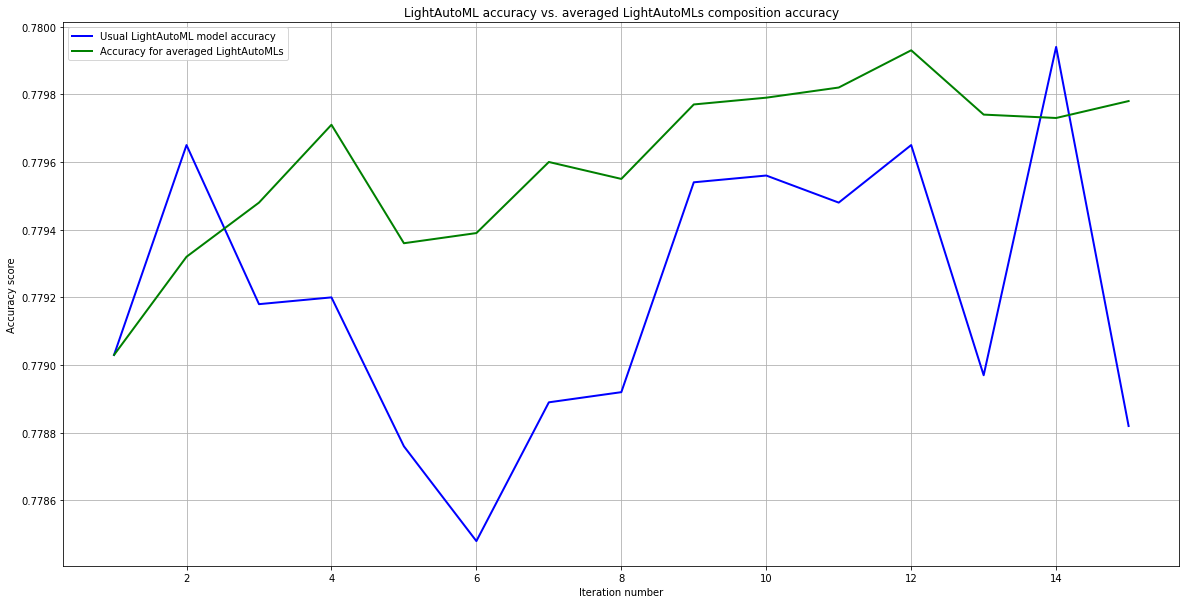

In [11]:
##visualize modelling results

plt.figure(figsize = (20, 10))
plt.plot(range(1, cnt_trained + 1), [res[0] for res in results], color = 'b', linewidth = 2, label = 'Usual LightAutoML model accuracy')
plt.plot(range(1, cnt_trained + 1), [res[1] for res in results], color = 'g', linewidth = 2, label = 'Accuracy for averaged LightAutoMLs')
plt.grid()
plt.legend()
plt.title('LightAutoML accuracy vs. averaged LightAutoMLs composition accuracy')
plt.xlabel('Iteration number')
plt.ylabel('Accuracy score')
plt.show()

In [12]:
##calaculate the mean accuracy
mean_accuracy = np.mean([res[0] for res in results])
print(mean_accuracy)

0.7792046666666667


In [15]:
#calculate the difference in scores of each  model
eval_differences=np.array([res[1] - mean_accuracy for res in results])
print(eval_differences)

[-0.00017467  0.00011533  0.00027533  0.00050533  0.00015533  0.00018533
  0.00039533  0.00034533  0.00056533  0.00058533  0.00061533  0.00072533
  0.00053533  0.00052533  0.00057533]


In [18]:
##prepare the model  for submission
sample_submission = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\sample_submission.csv')
sample_submission['Survived'] = ((test_pred_full / cnt_trained) > 0.5).astype(int)
sample_submission.to_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\light.csv', index = False)